Validation of the classification based on the WFsim

Buggs in the WFsim that are important to keep in mind:
 -  There is no double photo-emission taken into account
 -  There may be only ~ 500 events before the WFsim crashes
 
 
Possible extensions:
 - Add afterpulse boolian to the 'truth' info
 - Do the same for the other detector types

In [1]:
import strax
import straxen

/project2/lgrandi/xenonnt/development/lib/python3.6/site-packages/datashader-0.7.0-py3.6.egg/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [2]:
import wfsim

We include recarray_tools.py here that is used to add columns and do things with structured arrays

In [3]:
# %load recarray_tools.py
import numpy as np
from numpy.lib import recfunctions
from collections import OrderedDict

rename_fields = recfunctions.rename_fields


def append_fields(base, names, data, dtypes=None, fill_value=-1, 
                  usemask=False,   # Different from recfunctions default
                  asrecarray=False):
    """Append fields to numpy structured array
    Does nothing if array already has fields with the same name.
    """
    if isinstance(names, (tuple, list)):
        not_yet_in_data = True ^ np.in1d(names, base.dtype.names)
        if dtypes is None:
            dtypes = [d.dtype for d in data]
        # Add multiple fields at once
        return recfunctions.append_fields(base, 
                                          np.array(names)[not_yet_in_data].tolist(), 
                                          np.array(data)[not_yet_in_data].tolist(), 
                                          np.array(dtypes)[not_yet_in_data].tolist(), 
                                          fill_value, usemask, asrecarray)
    else:
        # Add single field
        if names in base.dtype.names:
            return base
        else:
            return recfunctions.append_fields(base, names, data, dtypes, 
                                              fill_value, usemask, asrecarray)

def drop_fields(arr, *args, **kwargs):
    """Drop fields from numpy structured array
    Gives error if fields don't exist
    """
    return recfunctions.drop_fields(arr, usemask=False, *args, **kwargs)


def drop_fields_if_exist(arr, fields):
    return drop_fields(arr, [f for f in fields if f in arr.dtype.names])


def fields_view(arr, fields):
    """View one or several columns from a numpy record array"""
    # Single field is easy:
    if isinstance(fields, str):
        return arr[fields]
    for f in fields:
        if f not in arr.dtype.names:
            raise ValueError("Field %s is not in the array..." % f)
    # Don't know how to do it for multiple fields, make a copy for now... (probably?)
    return drop_fields(arr, [f for f in arr.dtype.names if f not in fields])
    # The solution in http://stackoverflow.com/questions/15182381/how-to-return-a-view-of-several-columns-in-numpy-structured-array
    # doesn't work in combination with filter_on_fields...
    # dtype2 = np.dtype({name:arr.dtype.fields[name] for name in columns})
    # return np.ndarray(arr.shape, dtype2, arr, 0, arr.strides)    
    
    
def filter_on_fields(to_filter, for_filter, filter_fields, filter_fields_2=None, return_selection=False):
    """Returns entries of to_filter whose combination of the filter_fields values are present in for_filter.
    filter_fields_2: names of filter_fields in for_filter (if different than in to_filter)
   If return_selection, will instead
    """
    a = np.array(fields_view(to_filter, filter_fields))
    if filter_fields_2 is None:
        filter_fields_2 = filter_fields
    b = np.array(fields_view(for_filter, filter_fields_2))
    # Rename the fields, if needed
    # If only one field is selected, this won't be needed (and would return None instead of working)
    if not isinstance(filter_fields, str) and len(filter_fields) > 1:
        b = recfunctions.rename_fields(b, dict(zip(filter_fields_2, filter_fields)))
    selection = np.in1d(a, b)
    if return_selection:
        return selection
    else:
        return to_filter[selection]

def group_by(x, group_by_fields='Event', return_group_indices=False):
    """Splits x into LIST of arrays, each array with rows that have same group_by_fields values.
    Gotchas:
        Assumes x is sorted by group_by_fields (works in either order, reversed or not)
        Does NOT put in empty lists if indices skip a value! (e.g. events without peaks)
    If return_indices=True, returns list of arrays with indices of group elements in x instead
    """

    # Support single index and list of indices
    try:
        group_by_fields[0]
    except TypeError:
        group_by_fields = tuple(group_by_fields)

    # Define array we'll split
    if return_group_indices:
        to_return = np.arange(len(x))
    else:
        to_return = x

    # Indices to determine split points from
    indices = fields_view(x, group_by_fields)

    # Should we split at all?
    if indices[0] == indices[-1]:
        return [to_return]
    else:
        # Split where indices change value
        split_points = np.where((np.roll(indices, 1)!= indices))[0]
        # 0 shouldn't be a split_point, will be in it due to roll (and indices[0] != indices[-1]), so remove it
        split_points = split_points[1:]
        return np.split(to_return, split_points)
       

def dict_group_by(x, group_by_fields='Event', return_group_indices=False):
    """Same as group_by, but returns OrderedDict of value -> group, 
    where value is the value (or tuple of values) of group_by_fields in each subgroup
    """
    groups = group_by(x, group_by_fields, return_group_indices)
    return OrderedDict([(fields_view(gr[0:1], group_by_fields)[0], gr) for gr in groups])


def fields_data(arr, ignore_fields=None):
    if ignore_fields is None:
        ignore_fields = []
    """Returns list of arrays of data for each single field in arr"""
    return [arr[fn] for fn in arr.dtype.names if fn not in ignore_fields]


In [4]:
import numpy as np
import pandas as pd


instruction_dtype = [('event_number', np.int), ('type', '<U2'), ('t', np.int), 
    ('x', np.float32), ('y', np.float32), ('z', np.float32), 
    ('amp', np.int), ('recoil', '<U2')]

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(2 * n, dtype=instruction_dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
#     print(uniform_times)
    instructions['t'] = np.repeat(uniform_times, 2) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s1', 's2'], n)
    instructions['recoil'] = ['er' for i in range(n * 2)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 2)
    instructions['y'] = np.repeat(r * np.sin(t), 2)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 2)

    nphotons = np.random.uniform(200, 2050, n)
    nelectrons = 10 ** (np.random.uniform(1, 4, n))
    instructions['amp'] = np.vstack([nphotons, nelectrons]).T.flatten().astype(int)

    return instructions

c = dict(event_rate = 500, chunk_size=1, nchunk=1)
inst = rand_instructions(c)
_ = pd.DataFrame(inst).to_csv('test_uni.csv', index=False)

In [5]:
st = strax.Context(
register=[wfsim.RawRecordsFromFax],
config=dict(fax_file='./test_uni.csv'),
**straxen.contexts.common_opts)

In [6]:
# Just some id from post-SR1, so the corrections work
run_id = '180519_1902'

In [7]:
!rm -r strax_data
peaks = st.make(run_id, 'peak_basics')

Simulating Raw Records: 100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]


Source finished!


In [8]:
truth = st.get_array(run_id, 'truth')
data = st.get_array(run_id, ['peak_basics','peak_classification'])

This is to compensate for the fact that we dont have event numbers (Binning in time to group peaks)

In [9]:
n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
c['total_time'] = c['chunk_size'] * c['nchunk']
timing_grid = np.linspace(0, c['total_time'], n+1) * 1e9
#timing_grid

In [10]:
### Proxy for event number

truth = append_fields(truth, 'merge_index',np.digitize(truth['t'], timing_grid))
data = append_fields(data, 'merge_index',np.digitize(data['time'], timing_grid))

In [11]:
### Proxy for area of truth peak

truth = append_fields(truth, 'area', truth['n_photon'])

**There is a bug that the types are listed here as strings, where in strax they are integers**
The code here is to change that such that we can compare them directly

In [12]:
###!! 
###!! 
###!!
###!!

truth = append_fields(truth, 'typeint',np.ones(len(truth)), dtypes=np.int)
truth['typeint'][truth['type'] == 's2'] = np.int(2)
truth['typeint'][truth['type'] == 's1'] = np.int(1)
data = append_fields(data, 'typeint',data['type'], dtypes=np.int)


Proxy for left and right sides of peak in truth

In [13]:
### Proxy for left and right of peak
truth = append_fields(truth, ('time','endtime'), (truth['t_first_photon'],truth['t_last_photon']))

##3 Will need to add check to see if last electron is after last photon as below
#
#truth['endtime'] = truth['t_last_photon']
#mask = truth['endtime'] < truth['t_last_electron']
#truth['endtime'][mask] = truth['t_last_electron'][mask]

**We think there is a bug that makes all the peak times 500 ns earlier than the truth values**

We change the data here to move all times by 500 ns

In [14]:
###!!
###!!
###!! 
data['time'] = data['time']+500
data['endtime'] = data['endtime']+500

Here in match_peaks.py, written by Jelle, to compare two sets of peaks

Changes:
  -  Changed 'type' to 'typeint' because types are listed as integers in strax

In [15]:
# %load match_peaks.py
"""Utility to match peaks from results of different processor versions / processor and simulator
Jelle Aalbers, Nikhef, September 2015

Updated for strax, September 2019
Mike Clark
Joran Angevaare
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from tqdm import tqdm

import recarray_tools as rt
from multihist import Hist1d
try:
    from pax.datastructure import INT_NAN
except ImportError:
    INT_NAN = -99999


def match_peaks(allpeaks1, allpeaks2, matching_fuzz=1, unknown_types=[0],
                keep_tpc_only=True):
    """Perform peak matching between two numpy record arrays with fields: Event, left, right, type, area
    If a peak is split into many fragments (e.g. two close peaks split into three peaks),
    the results are unreliable and depend on which peak set is peaks1 and which is peaks2.

    Returns (allpeaks1, allpeaks2), each with three extra fields: id, outcome, matched_to
        id: unique number for each peak
        outcome: Can be one of:
            found:  Peak was matched 1-1 between peaks1 and peaks2 (type agrees, no other peaks in range).
                    Note that area, widths, etc. can still be quite different!
            missed: Peak is not present in the other list
            misid_as_XX: Peak is present in the other list, but has type XX
            merged: Peak is merged with another peak in the other list, the new 'super-peak' has the same type
            merged_to_XX: As above, but 'super-peak' has type XX
            split: Peak is split in the other list, but more than one fragment has the same type as the parent.
            chopped: As split, but one or several fragments are unclassified, exactly one has the correct type.
            split_and_unclassified: As split, but all fragments are unclassified in the other list.
            split_and_misid: As split, but at least one fragment has a different peak type.
        matched_to: id of matching in peak in the other list if outcome is found or misid_as_XX, INT_NAN otherwise.
    """

#     # Keep only tpc_peaks
#     if keep_tpc_only:
#         if 'detector' in allpeaks1.dtype.names:
#             allpeaks1 = allpeaks1[allpeaks1['detector'] == b'tpc']
#         if 'detector' in allpeaks2.dtype.names:
#             allpeaks2 = allpeaks2[allpeaks2['detector'] == b'tpc']

#     # Remove true photoionization afterpulse peaks (they were not in initial instruction file)
#     allpeaks1 = allpeaks1[allpeaks1['type'] != b'photoionization_afterpulse']
#     allpeaks2 = allpeaks2[allpeaks2['type'] != b'photoionization_afterpulse']

    # Append id, outcome and matched_to fields
    print("\tAppending extra fields...\n")
    allpeaks1 = append_fields(allpeaks1,
                                 ('id', 'outcome', 'matched_to'),
                                 (np.arange(len(allpeaks1)),
                                  np.array(['missed'] * len(allpeaks1), dtype='S32'),
                                  INT_NAN * np.ones(len(allpeaks1), dtype=np.int64)))
    allpeaks2 = append_fields(allpeaks2,
                                 ('id', 'outcome', 'matched_to'),
                                 (np.arange(len(allpeaks2)),
                                 np.array(['missed'] * len(allpeaks2), dtype='S32'),
                                 INT_NAN * np.ones(len(allpeaks2), dtype=np.int64)))
    # Group each peak by event in OrderedDict
    print("\tGrouping peaks 1 by event...\n")
    #print(allpeaks1)
    peaks1_by_event = dict_group_by(allpeaks1, 'merge_index')
    print("\tGrouping peaks 2 by event...\n")
    peaks2_by_event = dict_group_by(allpeaks2, 'merge_index')

    for event, peaks_1 in tqdm(peaks1_by_event.items(), desc='Matching peaks'):
        if event not in peaks2_by_event:
            continue
        peaks_2 = peaks2_by_event[event]

        for p1_i, p1 in enumerate(peaks_1):
            # Select all found peaks that overlap at least partially with the true peak
            selection = (peaks_2['time'] <= p1['endtime'] + matching_fuzz) & \
                        (peaks_2['endtime'] >= p1['time'] - matching_fuzz)
            matching_peaks = peaks_2[selection]

            if len(matching_peaks) == 0:
                # Peak was missed; that's the default outcome, no need to set anything
                pass

            elif len(matching_peaks) == 1:
                # A unique match! Hurray!
                p2 = matching_peaks[0]
                p1['matched_to'] = p2['id']
                p2['matched_to'] = p1['id']
                # Do the types match?
                if p1['typeint'] == p2['typeint']:
                    p1['outcome'] = p2['outcome'] = 'found'
                else:
                    if p1['typeint'] in unknown_types:
                        p2['outcome'] = 'unclassified'
                    else:
                        p2['outcome'] = 'misid_as_s%s' % p1['typeint']
                    if p2['typeint'] in unknown_types:
                        p1['outcome'] = 'unclassified'
                    else:
                        p1['outcome'] = 'misid_as_s%s' % p2['typeint']
                    # If the peaks are unknown in both sets, they will count as 'found'.
                    # Hmm....
                matching_peaks[0] = p2
            else:
                # More than one peak overlaps p1
                handle_peak_merge(parent=p1, fragments=matching_peaks, unknown_types=unknown_types)
                
            # matching_peaks is a copy, not a view, so we have to copy the results over to peaks_2 manually
            # Sometimes I wish python had references...
            for i_in_matching_peaks, i_in_peaks_2 in enumerate(np.where(selection)[0]):
                peaks_2[i_in_peaks_2] = matching_peaks[i_in_matching_peaks]

        # Match in reverse to detect merged peaks
        # >1 peaks in 1 may claim to be matched to a peak in 2, in which case we should correct the outcome...
        for p2_i, p2 in enumerate(peaks_2):
            selection = peaks_1['matched_to'] == p2['id']
            matching_peaks = peaks_1[selection]
            if len(matching_peaks) > 1:
                handle_peak_merge(parent=p2, fragments=matching_peaks, unknown_types=unknown_types)
                
            # matching_peaks is a copy, not a view, so we have to copy the results over to peaks_1 manually
            # Sometimes I wish python had references...
            for i_in_matching_peaks, i_in_peaks_1 in enumerate(np.where(selection)[0]):
                peaks_1[i_in_peaks_1] = matching_peaks[i_in_matching_peaks]
                    


    # Concatenate peaks again into result list
    # Necessary because group_by (and np.split inside that) returns copies, not views
    return np.concatenate(list(peaks1_by_event.values())), \
           np.concatenate(list(peaks2_by_event.values()))


def handle_peak_merge(parent, fragments, unknown_types):
    found_types = fragments['typeint']
    is_ok = found_types == parent['typeint']
    is_unknown = np.in1d(found_types, unknown_types)
    is_misclass = (True ^ is_ok) & (True ^ is_unknown)
    # We have to loop over the fragments to avoid making a copy
    for i in range(len(fragments)):
        if is_unknown[i] or is_misclass[i]:
            if parent['typeint'] in unknown_types:
                fragments[i]['outcome'] = 'merged_to_unknown'
            else:
                fragments[i]['outcome'] = 'merged_to_s%s' % parent['typeint']
        else:
            fragments[i]['outcome'] = 'merged'
        # Link the fragments to the parent
        fragments[i]['matched_to'] = parent['id']
    if np.any(is_misclass):
        parent['outcome'] = 'split_and_misid'
    # All fragments are either ok or unknown
    # If more than one fragment is given the same class
    # as the parent peak, then call it "split"
    elif len(np.where(is_ok)[0]) > 1:
        parent['outcome'] = 'split'
    elif np.all(is_unknown):
        parent['outcome'] = 'split_and_unclassified'
    # If exactly one fragment out of > 1 fragments
    # is correctly classified, then call the parent chopped
    else:
        parent['outcome'] = 'chopped'
    # We can't link the parent to all fragments... link to the largest one:
    parent['matched_to'] = fragments[np.argmax(fragments['area'])]['id']


outcome_colors = {
    'found':            'darkblue',
    'chopped':          'mediumslateblue',

    'missed':           'red',
    'merged':           'turquoise',
    'split':            'purple',

    'misid_as_s2':      'orange',
    'misid_as_s1':      'goldenrod',
    'split_and_misid':  'darkorange',
    'merged_to_s2':     'chocolate',
    'merged_to_s1':     'sandybrown',
    'merged_to_unknown': 'khaki',

    'unclassified':     'green',
    'split_and_unclassified':     'seagreen',
    'merged_and_unclassified':    'limegreen',
}



def peak_matching_histogram(results, histogram_key, bins=10):
    """Make 1D histogram of peak matching results (=peaks with extra fields added by matagainst histogram_key"""

    if histogram_key not in results.dtype.names:
        raise ValueError('Histogram key %s should be one of the columns in results: %s' % (histogram_key,
                                                                                           results.dtype.names))

    # How many true peaks do we have in each bin in total?
    n_peaks_hist = Hist1d(results[histogram_key], bins)
    hists = {'_total': n_peaks_hist}

    for outcome in np.unique(results['outcome']):
        # Histogram the # of peaks that have this outcome
        hist = Hist1d(results[results['outcome'] == outcome][histogram_key],
                      bins=n_peaks_hist.bin_edges)
        outcome = outcome
        hists[outcome] = hist

    return hists


def plot_peak_matching_histogram(*args, **kwargs):
    hists = peak_matching_histogram(*args, **kwargs)
    _plot_peak_matching_histogram(hists)


def _plot_peak_matching_histogram(hists):
    """Make 1D histogram of peak matching results (=peaks with extra fields added by matagainst histogram_key"""

    n_peaks_hist = hists['_total']

    for outcome, hist in hists.items():
        hist = hist.histogram.astype(np.float)

        if outcome == '_total':
            continue

        print("\t%0.2f%% %s" % (100 * hist.sum()/n_peaks_hist.n, outcome))

        # Compute Errors on estimate of a proportion
        # Should have vectorized this... lazy
        # Man this code is ugly!!!!
        limits_d = []
        limits_u = []
        for i, x in enumerate(hist):
            limit_d, limit_u = binom_interval(x, total=n_peaks_hist.histogram[i])
            limits_d.append(limit_d)
            limits_u.append(limit_u)
        limits_d = np.array(limits_d)
        limits_u = np.array(limits_u)

        # Convert hist to proportion
        hist /= n_peaks_hist.histogram.astype('float')

        color = outcome_colors.get(outcome, np.random.rand(3,))
        plt.errorbar(x=n_peaks_hist.bin_centers,
                     y=hist,
                     yerr=[hist - limits_d, limits_u - hist],
                     label=outcome,
                     color=color,
                     linestyle='-' if outcome == 'found' else '',
                     marker='s')

        # Wald intervals: not so good
        # errors = np.sqrt(
        #     hist*(1-hist)/all_true_peaks_histogram
        # )
        # plt.errorbar(x=bin_centers, y=hist, yerr = errors, label=outcome)

    plt.xlim(n_peaks_hist.bin_edges[0], n_peaks_hist.bin_edges[-1])
    plt.ylabel('Fraction of peaks')
    plt.ylim(0, 1)
    plt.legend(loc='lower right', shadow=True)
    legend = plt.legend(loc='best', prop={'size': 10})
    if legend and legend.get_frame():
        legend.get_frame().set_alpha(0.8)


def binom_interval(success, total, conf_level=0.95):
    """Confidence interval on binomial - using Jeffreys interval
    Code stolen from https://gist.github.com/paulgb/6627336
    Agrees with http://statpages.info/confint.html for binom_interval(1, 10)
    """
    # TODO: special case for success = 0 or = total? see wikipedia
    quantile = (1 - conf_level) / 2.
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    # If something went wrong with a limit calculation, report the trivial limit
    if np.isnan(lower):
        lower = 0
    if np.isnan(upper):
        upper = 1
    return lower, upper


Call with (truth, data)

In [16]:
truthmatched, datamatched = match_peaks(truth,data)

Matching peaks: 100%|██████████| 500/500 [00:00<00:00, 10513.41it/s]

	Appending extra fields...

	Grouping peaks 1 by event...

	Grouping peaks 2 by event...



Below is the output of match_peaks for the truth data.  
  - For each peak, **outcome** shows whether the peak was found, missed, merged, split up, or misidentified in the output of strax for the simulated data
  - **matched_to** shows which peak (peak_id in the other array) it was matched with, or the biggest peak it was matched with 

  <img src='toptruthmatches.png'>
  
Below is the corresponding match_index in the simulated data
  <img src='topdatamatch.png'>
  
You can see the splitting of the true s2 into an s1 and an s2

In [17]:
pd.DataFrame.from_records(truthmatched[['merge_index','type','time','area','endtime','matched_to','outcome']])


,merge_index,type,time,area,endtime,matched_to,outcome
0,1,s1,1.000028e+06,146.0,1.000175e+06,0,b'found'
1,1,s2,1.089310e+06,22768.0,1.093630e+06,1,b'found'
2,2,s1,3.000024e+06,204.0,3.000205e+06,13,b'found'
3,2,s2,3.533131e+06,1219.0,3.539084e+06,14,b'found'
4,3,s1,5.000034e+06,26.0,5.000127e+06,15,b'found'
...,...,...,...,...,...,...,...
995,498,s2,9.954772e+08,220.0,9.954814e+08,2599,b'split'
996,499,s1,9.970000e+08,85.0,9.970003e+08,2601,b'found'
997,499,s2,9.970979e+08,39846.0,9.971025e+08,2602,b'found'
998,500,s1,9.990000e+08,67.0,9.990002e+08,2616,b'found'


In [18]:
pd.DataFrame.from_records(datamatched[['merge_index','type','time','area','endtime','matched_to','outcome']]).head(20)
#pd.DataFrame.from_records(truthmatched[['merge_index','type','time','area','endtime','matched_to','outcome']])


,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,1000010,129.446457,1000230,0,b'found'
1,1,2,1089290,25081.115234,1095610,1,b'found'
2,1,0,1099480,21.928905,1100360,-99999,b'missed'
3,1,2,1105490,23.234241,1106120,-99999,b'missed'
4,1,1,1169140,32.687992,1169670,-99999,b'missed'
5,1,2,1183660,25.962490,1184260,-99999,b'missed'
6,1,2,1216820,37.807766,1217610,-99999,b'missed'
7,1,0,1307510,27.457943,1308200,-99999,b'missed'
8,1,0,1364010,13.493982,1364820,-99999,b'missed'
9,1,2,1414350,20.704613,1414870,-99999,b'missed'


In [19]:
pd.DataFrame.from_records(truthmatched[truthmatched['outcome'] == b'found'][['merge_index','type','time','area','endtime','matched_to','outcome']])

,merge_index,type,time,area,endtime,matched_to,outcome
0,1,s1,1.000028e+06,146.0,1.000175e+06,0,b'found'
1,1,s2,1.089310e+06,22768.0,1.093630e+06,1,b'found'
2,2,s1,3.000024e+06,204.0,3.000205e+06,13,b'found'
3,2,s2,3.533131e+06,1219.0,3.539084e+06,14,b'found'
4,3,s1,5.000034e+06,26.0,5.000127e+06,15,b'found'
...,...,...,...,...,...,...,...
829,498,s1,9.950000e+08,181.0,9.950002e+08,2598,b'found'
830,499,s1,9.970000e+08,85.0,9.970003e+08,2601,b'found'
831,499,s2,9.970979e+08,39846.0,9.971025e+08,2602,b'found'
832,500,s1,9.990000e+08,67.0,9.990002e+08,2616,b'found'


	2.70% b'chopped'
	83.40% b'found'
	4.20% b'missed'
	7.90% b'split'
	1.80% b'split_and_misid'


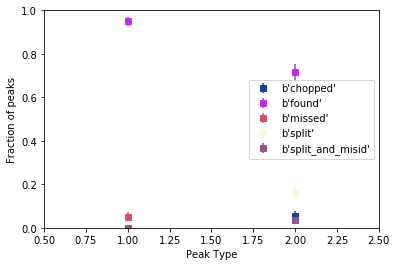

In [32]:
plot_peak_matching_histogram(truthmatched,'typeint',bins=[0.5,1.5,2.5])
plt.xlabel('Peak Type')
plt.show()

	31.83% b'found'
	8.28% b'merged'
	2.63% b'merged_to_s2'
	57.25% b'missed'


Text(0.5, 0, 'Peak Type')

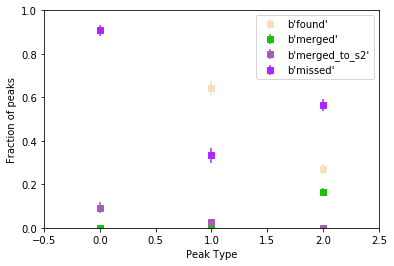

In [33]:
plot_peak_matching_histogram(datamatched,'typeint',bins= [-0.5,0.5,1.5,2.5])
plt.xlabel('Peak Type')

	2.70% b'chopped'
	83.40% b'found'
	4.20% b'missed'
	7.90% b'split'
	1.80% b'split_and_misid'


Text(0.5, 0, 'Depth')

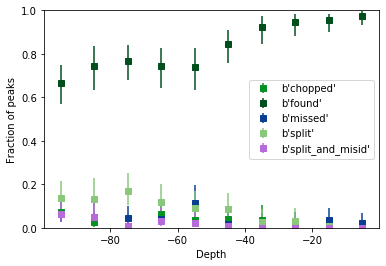

In [24]:
plot_peak_matching_histogram(truthmatched,'z')
plt.xlabel('Depth')

	31.83% b'found'
	8.28% b'merged'
	2.63% b'merged_to_s2'
	57.25% b'missed'


Text(0.5, 0, 'Area Fraction Top')

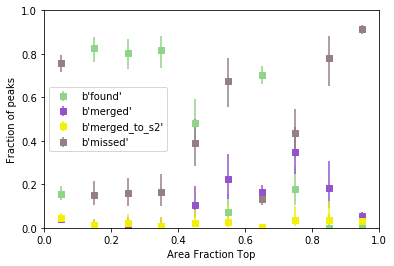

In [27]:
plot_peak_matching_histogram(datamatched,'area_fraction_top')
plt.xlabel('Area Fraction Top')